**Disclaimer**:

This notebook is based on @AMBROSM's notebook [PSS3E9 EDA which makes sense](https://www.kaggle.com/code/ambrosm/pss3e9-eda-which-makes-sense)

MattOP's [the great duplicate saga](https://www.kaggle.com/competitions/playground-series-s3e9/discussion/391011)

# Regression with a Tabular Concrete Strength Dataset
****

This playground competition is about **predicting the strength of the concrete** based on the different features provided in the dataset.

The dataset can be obtain using Kaggle API (`kaggle competitions download -c playground-series-s3e9`). As all the playground competitions the dataset has been generated synthetically. This is done in order to have a variaty of real dataset to practice and ensure test labels are not publicy available.

The real data set can be found at Kaggle datasets: [Concrete Strength Prediction](https://www.kaggle.com/datasets/mchilamwar/predict-concrete-strength) and it can be downloaded using the Kaggle API (`kaggle datasets download -d mchilamwar/predict-concrete-strength`).

#### Evaluation metric

The evaluation metric for this competition is the **Root Mean Squared Error (RMSE)**. 

$$\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

#### Submision file:

The Submission file must have the following format:
````csv
id,Strength
5439,55.2
5440,12.3
5441,83.4
etc.
````


### Feature description:

| Feature | Description |
| -------- | ----------- |
| CementComponent | Amount of cement mixed |
| BlastFurnaceSlag | Amount of Blast Furnace Slag mixed |
| FlyAshComponent | Amount of Fly Ash mixed |
| WaterComponent | Amount of water mixed |
| SuperplasticizerComponent | Amount of superplasticizer mixed |
| CoarseAggregateComponent | Amount of coarse aggregate mixed |
| FineAggregateComponent | Amount of fine aggregate mixed |
| AgeInDays | Number of days the concrete was left to dry |
| Strength | Final strength of the concrete (Target) |



## Objective of this notebook:
1. How to analyze the data
2. How to cross-validate and compare several models
3. How to engineer the most important features for a good linear model
4. How to ensemble several models to create a more powerful model

In [1]:
import os 
from pathlib import Path
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import datetime
from colorama import Fore, Style

from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ: 
    print('Running in Kaggle') # kaggle kernel
    path = Path('/kaggle/input')
    org_path = Path('/kaggle/input/')
else:
    print('Running locally')
    path = Path('.')
    org_path = Path('.')

Running locally


In [3]:
train = pd.read_csv(path/"train.csv", index_col='id')
test = pd.read_csv(path/"test.csv", index_col='id')
alldata = pd.concat([train, test], axis=0)
original = pd.read_csv(org_path/"ConcreteStrengthData.csv")
TARGET = 'Strength'
init_feat = list(test.columns)

### Cleaning data

In [4]:
print(f'Columns with different names: {train.columns[train.columns != original.columns]}')

Columns with different names: Index(['CementComponent'], dtype='object')


In [5]:
original.columns = original.columns.str.strip()

In [6]:
train.duplicated().sum(), test.duplicated().sum(), original.duplicated().sum()

(0, 1351, 25)

An important step in the data analysis is to check and analyze the duplicates in the data and draw conclusions from it. This is important because the duplicates can affect the model performance.


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5407 entries, 0 to 5406
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            5407 non-null   float64
 1   BlastFurnaceSlag           5407 non-null   float64
 2   FlyAshComponent            5407 non-null   float64
 3   WaterComponent             5407 non-null   float64
 4   SuperplasticizerComponent  5407 non-null   float64
 5   CoarseAggregateComponent   5407 non-null   float64
 6   FineAggregateComponent     5407 non-null   float64
 7   AgeInDays                  5407 non-null   int64  
 8   Strength                   5407 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 422.4 KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3605 entries, 5407 to 9011
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            3605 non-null   float64
 1   BlastFurnaceSlag           3605 non-null   float64
 2   FlyAshComponent            3605 non-null   float64
 3   WaterComponent             3605 non-null   float64
 4   SuperplasticizerComponent  3605 non-null   float64
 5   CoarseAggregateComponent   3605 non-null   float64
 6   FineAggregateComponent     3605 non-null   float64
 7   AgeInDays                  3605 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 253.5 KB


### Feature distributions

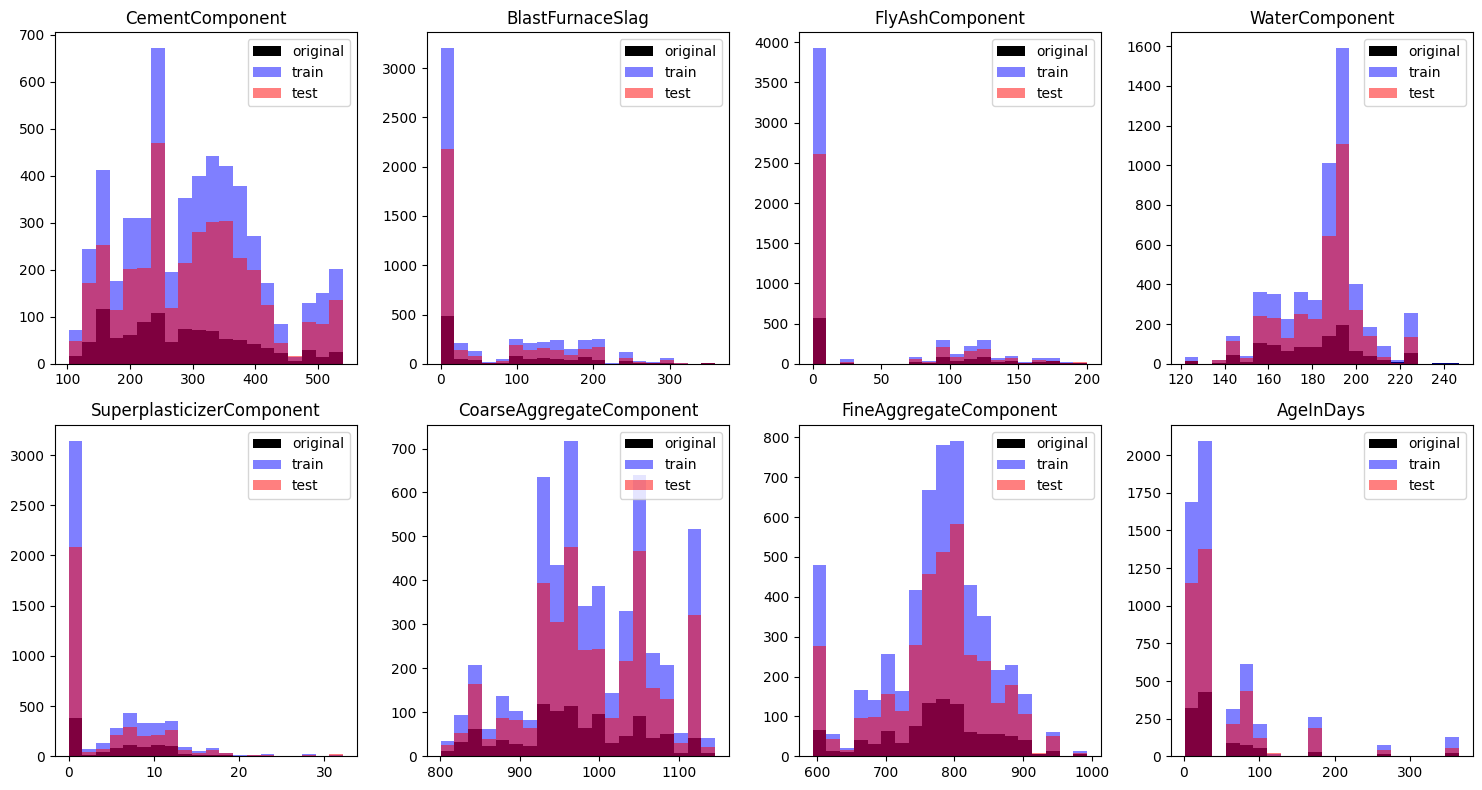

In [73]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
for col, ax in zip(train.columns, axs.flatten()):
    ax.hist(original[col], bins=20, alpha=1, color='black')
    ax.hist(train[col], bins=20, alpha=0.5, color='b')
    ax.hist(test[col], bins=20, alpha=0.5, color='r')
    ax.set_title(col)
    ax.legend(['original', 'train', 'test'], loc='upper right')
plt.tight_layout()
plt.show()

What can you get from the feature distributions?

1. There are a huge amount of observation with value zero in the `BlastFurnaceSlag`, `FlyAshComponent`, `SuperplasticizerComponent`, and `AgeinDays` features. This can be a sign of missing data or a sign that the feature is not important for the model. We could create a new features to indicate if the value is zero or not in these features.
2. In the feature `AgeInDays` we can clearly distinguish groups of observations. This can be a sign that the feature is important for the model.

In [10]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9012 entries, 0 to 9011
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            9012 non-null   float64
 1   BlastFurnaceSlag           9012 non-null   float64
 2   FlyAshComponent            9012 non-null   float64
 3   WaterComponent             9012 non-null   float64
 4   SuperplasticizerComponent  9012 non-null   float64
 5   CoarseAggregateComponent   9012 non-null   float64
 6   FineAggregateComponent     9012 non-null   float64
 7   AgeInDays                  9012 non-null   int64  
 8   Strength                   5407 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 704.1 KB


Almost 60% of the data don't contain BlastFurnaceSlag

In [11]:

alldata.BlastFurnaceSlag[alldata.BlastFurnaceSlag == 0.0].count() / alldata.shape[0]

0.5901020861074123

More than 72% of the data don't contain FlyAshComponent

In [12]:
alldata.FlyAshComponent[alldata.FlyAshComponent == 0.0].count() / alldata.shape[0]

0.7248113626276076

Almost 58% of the data don't contain Superplasticizer

In [13]:
alldata.SuperplasticizerComponent[alldata.SuperplasticizerComponent == 0.0].count() / alldata.shape[0]

0.579560585885486

Here is a more detail analysis of the `Age in Days` feature. In a preliminary analysis the data sugest that we could categorize the `Age in Days` feature in 3 groups: 1-7 days, 14-28 days, 56-120 days, and more the 180 days. This can be a good feature for the model.

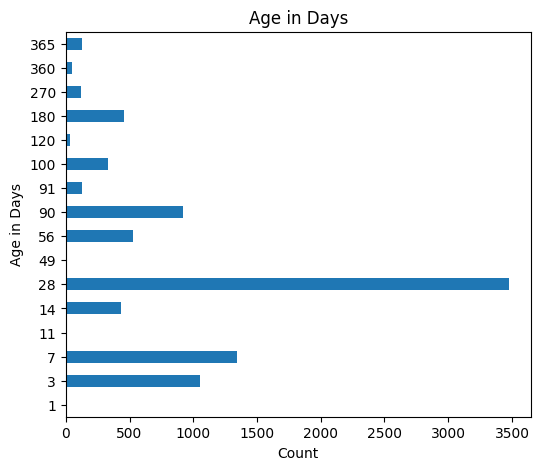

In [14]:
age_days = alldata.AgeInDays.value_counts().sort_index()
plt.figure(figsize=(6, 5))
age_days.plot(kind='barh')
plt.title('Age in Days')
plt.xlabel('Count')
plt.ylabel('Age in Days');



### Correlations

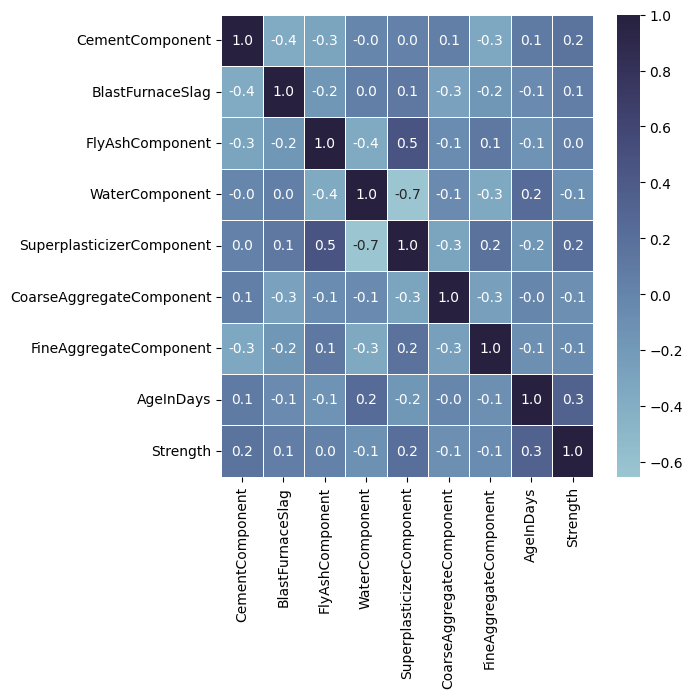

In [15]:
corr = train.corr()
plt.figure(figsize=(6, 6))
cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(corr, annot=True, fmt='.1f', cmap=cmap, center=0, linewidths=0.4);

The correlations provide insight into how these variable are related to each other and the target variable. 

The `CementComponent` and `SuperplasticizerComponent` are correlated features with the `Strength` (target variable), indicating that as the amount of cement increases, the strength of the concrete also increases. The same is true for the `SuperplasticizerComponent` feature.

The `WaterComponent`, `CoarseAggregateComponent`, and `FineAggregateComponent` are negatively correlated with the `Strength` feature. This indicates that as the amount of water, coarse aggregate, and fine aggregate increases, the strength of the concrete decreases.

The `AgeInDays` is the most correlated feature with the `Strength` feature. This indicates that the longer the concrete is left to dry, the stronger it becomes.

The `FlyAshComponent` seem to have not correlation with the `Strength` feature. 

There're also some correlations between the features. For example, the `CementComponent` , `BlashFurnaceSlag`, and `FineAggregateComponent` are negatively correlated. This might indicate that they are substitute products. 

`CoarseAggregateComponent` is negatively correlated with all the feature except `CementComponent`.

## Model Baselines

### Cross-validation function

In [16]:
N_SPLITS = 5
SEED = 0

In [17]:
OOF = {}
TST = {}
MAKE_PREDS = True

In [18]:
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
def cross_val(model, name, data, test, features, target):
    t0 = datetime.datetime.now()
    scores = []
    oof_splits = np.full_like(data[target], 0.0, dtype=float)
    for fold, (idx_t, idx_v) in enumerate(kf.split(data)):
        X_t = data.loc[idx_t, features]
        X_v = data.loc[idx_v, features]
        y_t = data.loc[idx_t, target]
        y_v = data.loc[idx_v, target]
        print(f'{name} -- Fold -- {fold+1}')
        print(f'Train: {X_t.shape[0]} Validation: {X_v.shape[0]}')
        # fit the model
        model.fit(X_t, y_t)
        # OOF preds
        y_pred = np.zeros_like(y_v, dtype=float)
        y_pred = model.predict(X_v)
        oof_splits[idx_v] = y_pred
        # get the score
        tr_rmse = root_mean_squared_error(y_t, model.predict(X_t))
        va_rmse = root_mean_squared_error(y_v, y_pred)
        scores.append(va_rmse)
        print(f'Train RMSE: {tr_rmse:.4f} Validation RMSE: {va_rmse:.4f}')
        print('-'*50)
    # mean and std of RMSE
    print(f'OOF RMSE Average: {np.mean(scores):.4f} ± {np.std(scores):.4f}')
    # store OOF in the dict
    OOF[name] = oof_splits
    if MAKE_PREDS:
        # fit on all data and predict the test data
        model.fit(data[features], data[target])
        TST[name] = model.predict(test[features])

### Linear Baseline

In [19]:
model = make_pipeline(StandardScaler(), LinearRegression())
cross_val(model, 'LinearRegression', train, test, init_feat, TARGET)

LinearRegression -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 14.5570 Validation RMSE: 14.6579
--------------------------------------------------
LinearRegression -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 14.5783 Validation RMSE: 14.5527
--------------------------------------------------
LinearRegression -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 14.5392 Validation RMSE: 14.7118
--------------------------------------------------
LinearRegression -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 14.5602 Validation RMSE: 14.6256
--------------------------------------------------
LinearRegression -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 14.6088 Validation RMSE: 14.4595
--------------------------------------------------
OOF RMSE Average: 14.6015 ± 0.0877


In [20]:
model = make_pipeline(StandardScaler(), Ridge(alpha=30))
cross_val(model, 'Ridge', train, test, init_feat, TARGET)

Ridge -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 14.5571 Validation RMSE: 14.6553
--------------------------------------------------
Ridge -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 14.5784 Validation RMSE: 14.5537
--------------------------------------------------
Ridge -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 14.5393 Validation RMSE: 14.7114
--------------------------------------------------
Ridge -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 14.5603 Validation RMSE: 14.6259
--------------------------------------------------
Ridge -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 14.6090 Validation RMSE: 14.4597
--------------------------------------------------
OOF RMSE Average: 14.6012 ± 0.0871


In [21]:
for df in [train, test]:
    df['hasBlastFurnaceSlag'] = df.BlastFurnaceSlag.ne(0).astype(int)
    df['hasFlyAshComponent'] = df.FlyAshComponent.ne(0).astype(int)
    df['hasSuperplasticizerComponent'] = df.SuperplasticizerComponent.ne(0).astype(int)


In [22]:
flag_cols = ['hasBlastFurnaceSlag', 'hasFlyAshComponent', 'hasSuperplasticizerComponent']

In [23]:
train.columns

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength', 'hasBlastFurnaceSlag', 'hasFlyAshComponent',
       'hasSuperplasticizerComponent'],
      dtype='object')

In [24]:
model = make_pipeline(StandardScaler(), Ridge(alpha=73))
cross_val(model, 'Ridge', train, test, init_feat, TARGET)

Ridge -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 14.5578 Validation RMSE: 14.6520
--------------------------------------------------
Ridge -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 14.5790 Validation RMSE: 14.5555
--------------------------------------------------
Ridge -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 14.5399 Validation RMSE: 14.7111
--------------------------------------------------
Ridge -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 14.5609 Validation RMSE: 14.6267
--------------------------------------------------
Ridge -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 14.6097 Validation RMSE: 14.4609
--------------------------------------------------
OOF RMSE Average: 14.6012 ± 0.0861


In [37]:
model = make_pipeline(
    ColumnTransformer([
        ('scaler_poly', make_pipeline(StandardScaler(), PolynomialFeatures(2)), init_feat)
    ], remainder='passthrough'),
    Ridge(alpha=73)
)
cross_val(model, 'Ridge_poly2', train, test, init_feat, TARGET)

Ridge_poly2 -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 13.1495 Validation RMSE: 13.4287
--------------------------------------------------
Ridge_poly2 -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 13.1606 Validation RMSE: 13.3959
--------------------------------------------------
Ridge_poly2 -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 13.1998 Validation RMSE: 13.2418
--------------------------------------------------
Ridge_poly2 -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 13.1976 Validation RMSE: 13.2781
--------------------------------------------------
Ridge_poly2 -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 13.2048 Validation RMSE: 13.2589
--------------------------------------------------
OOF RMSE Average: 13.3207 ± 0.0764


In [38]:
model = make_pipeline(
    ColumnTransformer([
        ('scaler_poly', make_pipeline(StandardScaler(), PolynomialFeatures(3)), init_feat)
    ], remainder='passthrough'),
    Ridge(alpha=73)
)
cross_val(model, 'Ridge_poly3', train, test, init_feat, TARGET)

Ridge_poly3 -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 12.2955 Validation RMSE: 12.7156
--------------------------------------------------
Ridge_poly3 -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 12.2441 Validation RMSE: 13.1551
--------------------------------------------------
Ridge_poly3 -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 12.2796 Validation RMSE: 12.7335
--------------------------------------------------
Ridge_poly3 -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 12.2669 Validation RMSE: 12.8050
--------------------------------------------------
Ridge_poly3 -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 12.2767 Validation RMSE: 12.7746
--------------------------------------------------
OOF RMSE Average: 12.8367 ± 0.1622


In [39]:
# adding new features
model = make_pipeline(
    ColumnTransformer([
        ('scaler_poly', make_pipeline(StandardScaler(), PolynomialFeatures(2)), init_feat)
    ], remainder='passthrough'),
    Ridge(alpha=73)
)
cross_val(model, 'Ridge_poly2_extf', train, test, init_feat + flag_cols, TARGET)

Ridge_poly2_extf -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 13.1441 Validation RMSE: 13.4172
--------------------------------------------------
Ridge_poly2_extf -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 13.1554 Validation RMSE: 13.3838
--------------------------------------------------
Ridge_poly2_extf -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 13.1901 Validation RMSE: 13.2420
--------------------------------------------------
Ridge_poly2_extf -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 13.1877 Validation RMSE: 13.2812
--------------------------------------------------
Ridge_poly2_extf -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 13.1980 Validation RMSE: 13.2515
--------------------------------------------------
OOF RMSE Average: 13.3152 ± 0.0717


In [40]:
model = make_pipeline(
    ColumnTransformer([
        ('scaler_poly', make_pipeline(StandardScaler(), PolynomialFeatures(3)), init_feat)
    ], remainder='passthrough'),
    Ridge(alpha=73)
)
cross_val(model, 'Ridge_poly3_extf', train, test, init_feat + flag_cols, TARGET)

Ridge_poly3_extf -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 12.2907 Validation RMSE: 12.7089
--------------------------------------------------
Ridge_poly3_extf -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 12.2398 Validation RMSE: 13.1410
--------------------------------------------------
Ridge_poly3_extf -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 12.2742 Validation RMSE: 12.7298
--------------------------------------------------
Ridge_poly3_extf -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 12.2594 Validation RMSE: 12.8042
--------------------------------------------------
Ridge_poly3_extf -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 12.2725 Validation RMSE: 12.7701
--------------------------------------------------
OOF RMSE Average: 12.8308 ± 0.1585


After adding the new flag columns we can see some improvements in the oof score

In [41]:
model = make_pipeline(ColumnTransformer([
    ('scaler_spline', make_pipeline(StandardScaler(), SplineTransformer(degree=3)), init_feat)
], remainder='passthrough'), Ridge(alpha=73))
cross_val(model, 'Ridge_spline_extf', train, test, init_feat+flag_cols, TARGET)

Ridge_spline_extf -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 13.2105 Validation RMSE: 13.2486
--------------------------------------------------
Ridge_spline_extf -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 13.2099 Validation RMSE: 13.2376
--------------------------------------------------
Ridge_spline_extf -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 13.2017 Validation RMSE: 13.2748
--------------------------------------------------
Ridge_spline_extf -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 13.2075 Validation RMSE: 13.3081
--------------------------------------------------
Ridge_spline_extf -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 13.2168 Validation RMSE: 13.2591
--------------------------------------------------
OOF RMSE Average: 13.2656 ± 0.0245


Best linear model so far:
1. Ridge polynomial regressor degree 3 - OOF RMSE Average: 12.8308 ± 0.1585
2. Ridge using spline transformer - OOF RMSE Average: 13.2656 ± 0.0245

## Random Forest

In [42]:
model = RandomForestRegressor(random_state=SEED)
cross_val(model, 'RF_ext', train, test, init_feat+flag_cols, TARGET)

RF_ext -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 8.0678 Validation RMSE: 12.7401
--------------------------------------------------
RF_ext -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 8.0717 Validation RMSE: 12.8191
--------------------------------------------------
RF_ext -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 7.9844 Validation RMSE: 12.7456
--------------------------------------------------
RF_ext -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 7.9610 Validation RMSE: 13.1141
--------------------------------------------------
RF_ext -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 8.1258 Validation RMSE: 13.0447
--------------------------------------------------
OOF RMSE Average: 12.8927 ± 0.1565


In [70]:
rf_params = {
    'n_estimators': 500,
    'random_state':SEED,
    'max_depth': 6,
    'max_features': 0.6,
    'max_samples': 0.6,
}
model = RandomForestRegressor(**rf_params)
cross_val(model, 'RF_1', train, test, init_feat+flag_cols, TARGET)

RF_1 -- Fold -- 1
Train: 4325 Validation: 1082
Train RMSE: 11.5289 Validation RMSE: 12.0383
--------------------------------------------------
RF_1 -- Fold -- 2
Train: 4325 Validation: 1082
Train RMSE: 11.5246 Validation RMSE: 12.1519
--------------------------------------------------
RF_1 -- Fold -- 3
Train: 4326 Validation: 1081
Train RMSE: 11.5688 Validation RMSE: 11.9833
--------------------------------------------------
RF_1 -- Fold -- 4
Train: 4326 Validation: 1081
Train RMSE: 11.4779 Validation RMSE: 12.2994
--------------------------------------------------
RF_1 -- Fold -- 5
Train: 4326 Validation: 1081
Train RMSE: 11.5371 Validation RMSE: 12.1629
--------------------------------------------------
OOF RMSE Average: 12.1272 ± 0.1097


In [ ]:
OOF RMSE Average: 12.1272 ± 0.1097
OOF RMSE Average: 12.1274 ± 0.1084
OOF RMSE Average: 12.1351 ± 0.1128
OOF RMSE Average: 12.1379 ± 0.1099
OOF RMSE Average: 12.1421 ± 0.1137
OOF RMSE Average: 12.1737 ± 0.1277

From the discussion forum in kaggle, [post](https://www.kaggle.com/competitions/playground-series-s3e9/discussion/391237)

@jonbown's wife is full time structural engineer and here are some insights from her:

1. The ratio of WaterComponent to CementComponent is very important
2. The lower the WaterComponent to CementComponent ratio, the faster it dries and the stronger it is in the long run.
3. Super Plasticizer is an expensive additive to concrete. It is typically used when higher than normal strength concrete is needed.
4. Coarse Aggregate is larger rocks that are added to the concrete to increase the strength.
5. Fine Aggregate is smaller rocks that are added to the concrete to fill air pockets but not as influencial on overall strength. The more fine you have the more water you need.
6. FlyAsh reduces the mixing water requirement and allows the concrete to gain strength over time and lower the upfront cost.
7. Blast Furnace Slag as the amount of this increases the late age compressive strength increases.
8. There have been some studies on FlyAsh/BlastFurnace ratio but nothing very conclusive in terms of strength

@ denisnikonoff also points out that what really matter is the ratio between the components. So standarization techniques can mess up everything.
